In [1]:
from keras.models import load_model

import pickle
import cv2
import h5py
import glob
import numpy as np
import natsort

from utils.generator import Generator
from utils.simple_resize import SimpleResize
from utils.mean_subtract import MeanSubtract

from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/home/yq/miniconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/yq/miniconda3/envs/tf/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Run the prediction on the test set

In [2]:
BS = 128

model = load_model("svhn.h5")

with h5py.File("hdf5/test.hdf5", "r") as f:
    labels = f["labels"][()]

means = pickle.load(open("rgb_means.pkl", "rb"))
sr = SimpleResize(54, 54)
ms = MeanSubtract(means["R"], means["G"], means["B"])
preprocessors = [sr, ms]
gen = Generator("hdf5/test.hdf5", BS, 1, preprocessors)

In [3]:
predictions = model.predict_generator(gen.generate(), steps=(gen.n_img//BS)+1) #steps+1 because not enough steps to loop all data
gen.close()

### Looking at the accuracy for every digit

In [4]:
accuracy = 0.0
print("Accuracies for every digits:")
for i in range(6):
    pred = predictions[i]
    pred = np.argmax(pred, axis=-1)
    label = labels[:, i]
    
    acc = accuracy_score(label, pred)
    
    if i != 5:
        print("Digit {}: {:.2f}".format(i+1, acc))
    else:
        print("Sequence length: {:.2f}\n".format(acc))
        
    accuracy += acc
        
print("Overall accuracy: {:.2f}".format(accuracy/6))

Accuracies for every digits:
Digit 1: 0.93
Digit 2: 0.92
Digit 3: 0.96
Digit 4: 0.99
Digit 5: 1.00
Sequence length: 0.96

Overall accuracy: 0.96


### Some visualization

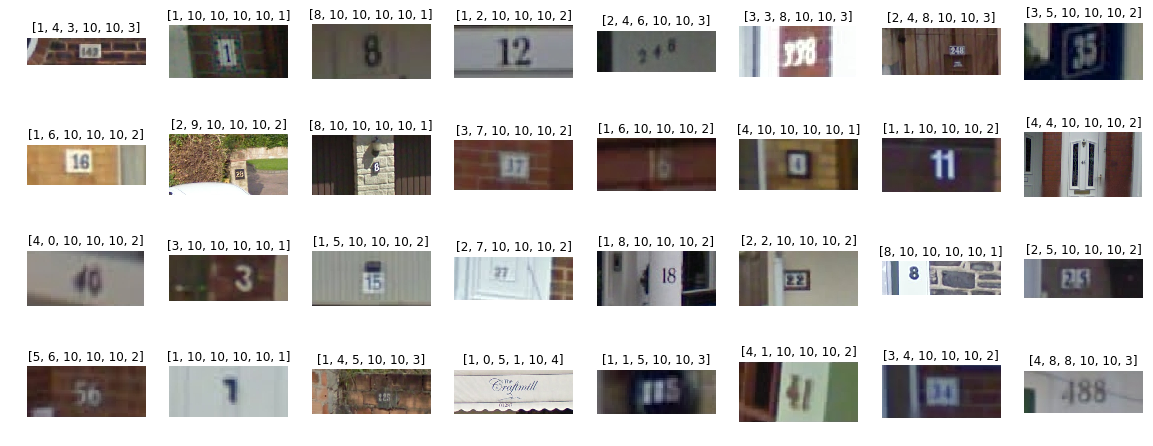

In [5]:
test_paths = natsort.natsorted(glob.glob("test/*.png"))

idxs = np.random.choice(len(test_paths), size=32)

plt.figure(figsize=(20, 8))
for n, i in enumerate(idxs):
    img = cv2.imread(test_paths[i])
    
    pred = []
    for p in predictions:
        temp = np.argmax(p, axis=-1)
        pred.append(temp[i])
        
    plt.subplot(4, 8, n+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(pred)
    
plt.show()